<a href="https://colab.research.google.com/github/valerio-unifei/ECO904/blob/main/ECO904_2024_1_Atividade_2_Etapa_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 2 - Etapa 1

[Proposta](https://docs.google.com/document/d/e/2PACX-1vTvlDZCbl8BtQfBQ3a0CPt_KDnxzQx_8E18iJMJxZ5R05cgX18hx0R8iwd5g3didFwDUHpJRRkqqQqs/pub)

Utilizar um exemplo com CNN para detectar classes
- Utilizar um exemplo pronto do Keras ([Exemplo](https://keras.io/examples/vision/image_classification_from_scratch/))
- Reduzir a resolução da imagem
- Montar uma rede neural profunda do zero
- Verificar resultados e tempo de aprendizagem


# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2023/11/09<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Kaggle Dataset: Corn or Maize Leaf Disease Dataset

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

In [ ]:
!kaggle datasets download 'smaranjitghose/corn-or-maize-leaf-disease-dataset'

100% 160M/161M [00:09<00:00, 20.6MB/s]
100% 161M/161M [00:09<00:00, 18.3MB/s]


In [ ]:
!unzip -qq corn-or-maize-leaf-disease-dataset.zip

replace data/Blight/Corn_Blight (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [ ]:
num_skipped = 0
for folder_name in ('Blight', 'Common_Rust','Gray_Leaf_Spot','Healthy'):
    folder_path = os.path.join('/content/data/', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## Generate a `Dataset`

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/data/",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 4113 files belonging to 4 classes.
Using 3291 files for training.
Using 822 files for validation.


In [ ]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

## Visualize the data

Here are the first 9 images in the training dataset.

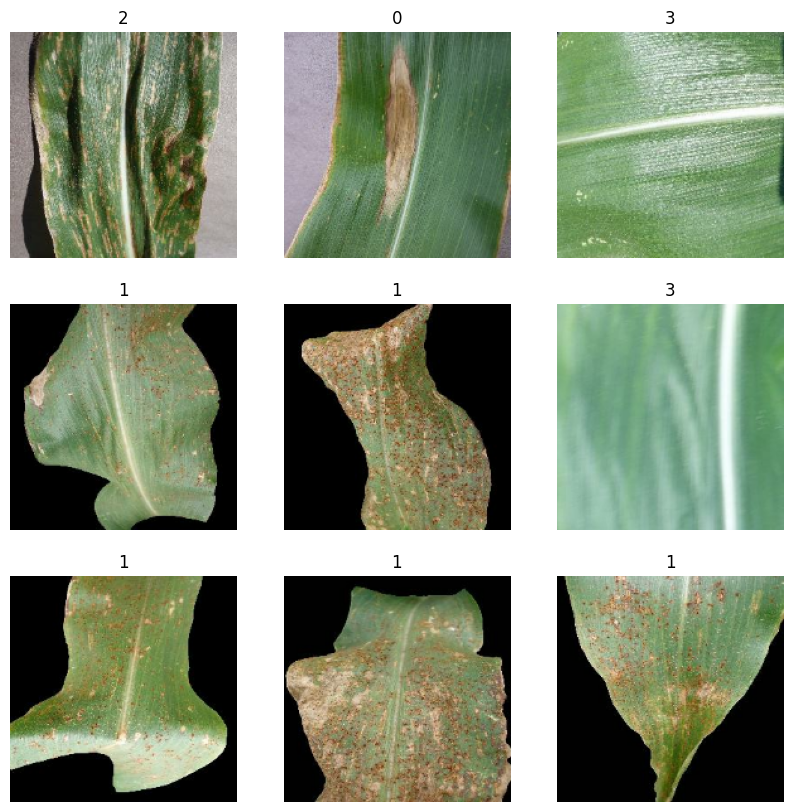

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

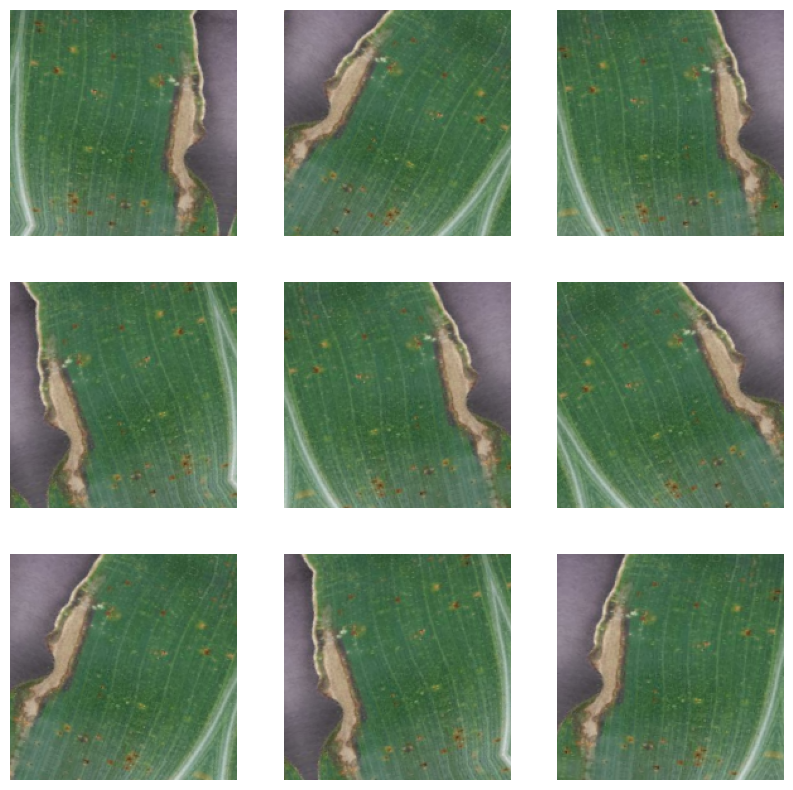

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [ ]:
input_shape=image_size + (3,)
num_classes=4
input_shape, num_classes

((180, 180, 3), 4)

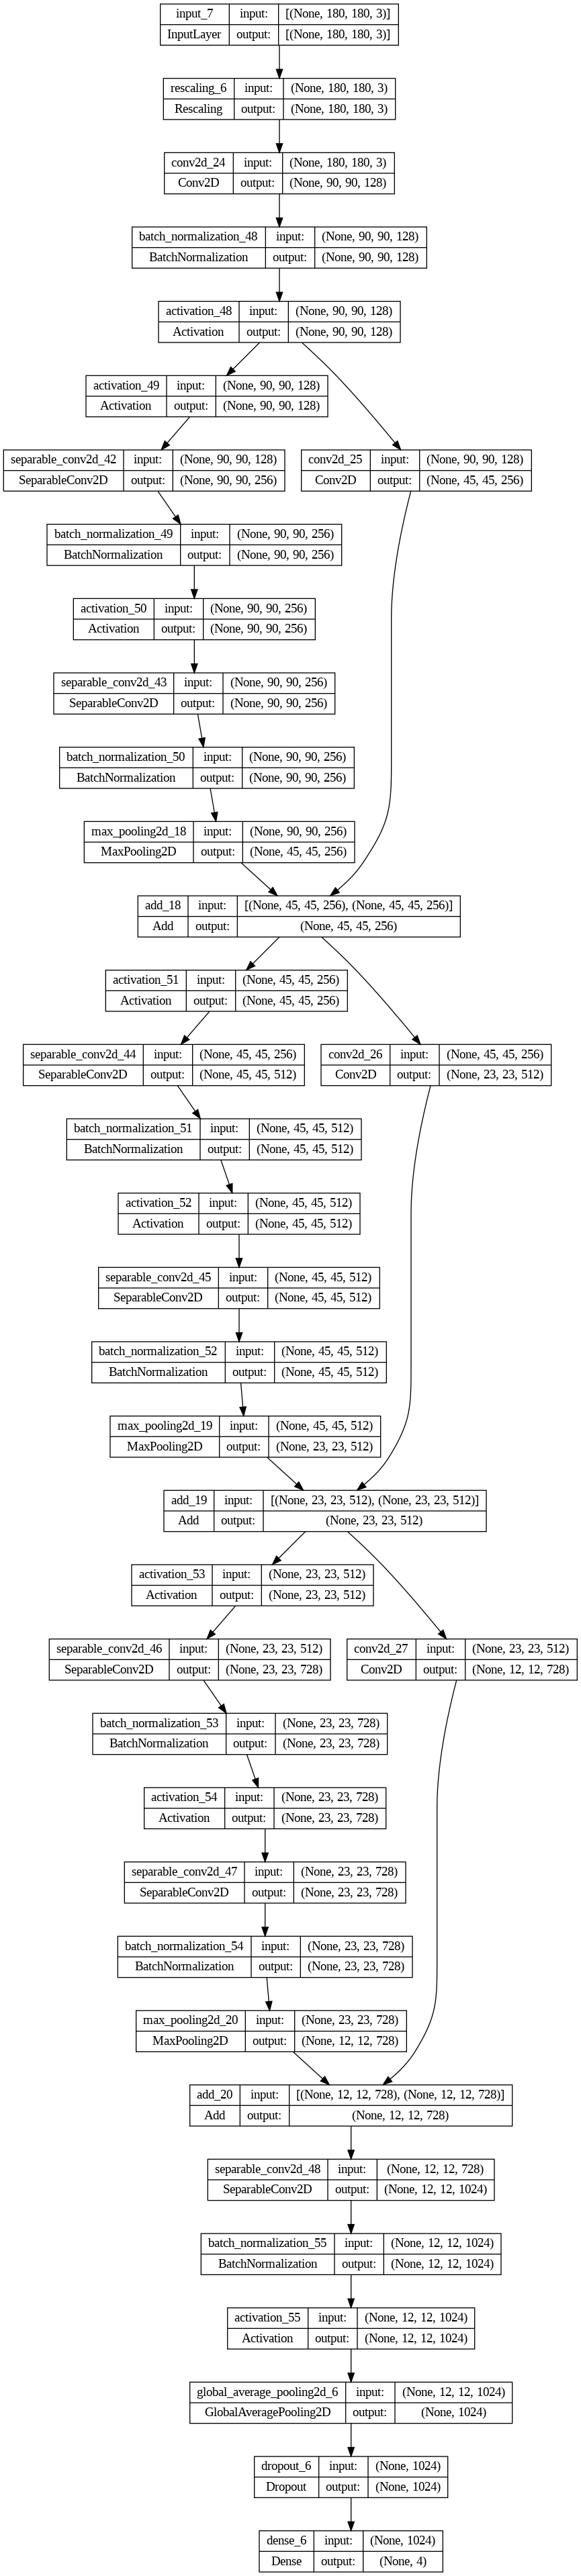

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape, num_classes)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.fit(
    train_ds,
    epochs=25,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
103/103 [==============================] - 67s 452ms/step - loss: 6.2906 - accuracy: 0.2723 - val_loss: 7.8118 - val_accuracy: 0.2530
Epoch 2/25
103/103 [==============================] - 34s 325ms/step - loss: 7.8811 - accuracy: 0.2786 - val_loss: 6.3406 - val_accuracy: 0.2530
Epoch 3/25
103/103 [==============================] - 36s 332ms/step - loss: 4.3024 - accuracy: 0.3467 - val_loss: 5.3693 - val_accuracy: 0.2543
Epoch 4/25
103/103 [==============================] - 35s 330ms/step - loss: 5.2200 - accuracy: 0.4752 - val_loss: 5.1516 - val_accuracy: 0.5377
Epoch 5/25
103/103 [==============================] - 35s 329ms/step - loss: 4.0002 - accuracy: 0.3616 - val_loss: 5.7365 - val_accuracy: 0.1800
Epoch 6/25
103/103 [==============================] - 35s 327ms/step - loss: 6.6442 - accuracy: 0.2385 - val_loss: 8.4124 - val_accuracy: 0.1095
Epoch 7/25
103/103 [==============================] - 35s 330ms/step - loss: 7.4724 - accuracy: 0.1854 - val_loss: 4.1423 - val_ac

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

AttributeError: module 'keras' has no attribute 'ops'

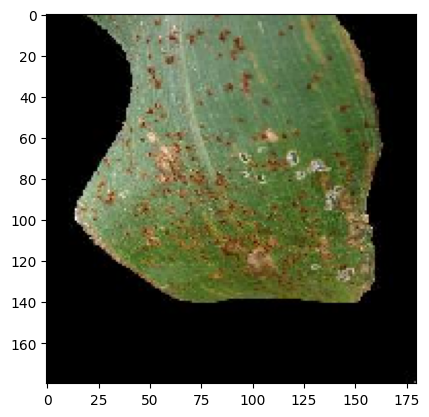

In [ ]:
img = keras.utils.load_img("/content/data/Common_Rust/Corn_Common_Rust (1003).JPG", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predictions